In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats


sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import*
mne.set_log_level('CRITICAL')

In [3]:

erp_times = create_erp_times(-0.5,0.5, 128)
ep_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz_corrected'
mapchange_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected'

## Individual subject plot

In [143]:
sub = '05'
period = 'post'
ch_to_plot = 'Cz'


time_to_plot = 0.1
time_idx = time_index_custom([time_to_plot], erp_times)[0]



#read epochs data
ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
eps = mne.read_epochs(ep_file).get_data()

#read mapchange data
mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
mapchange_df = pd.read_csv(mapchange_file)
mapchange_df_firsts = mapchange_df.query('type =="first"')
mapchange_df_others = mapchange_df.query('type =="other"')

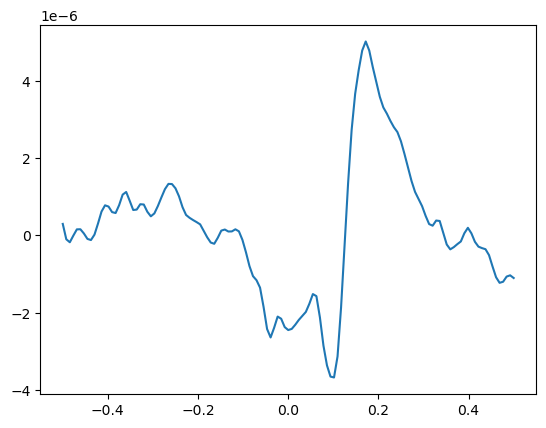

In [144]:
plt.plot(erp_times,eps[:, 47, :].mean(axis = 0))

ValueError: x and y must be the same size

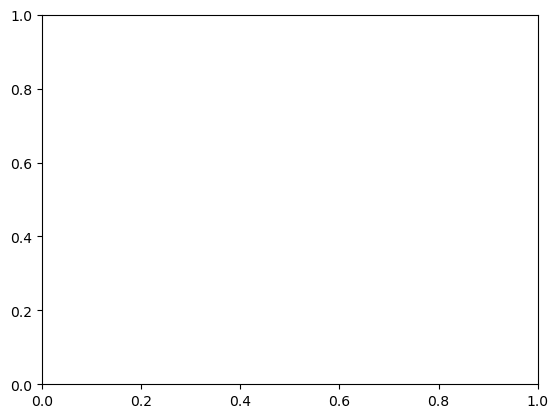

In [145]:
for i, row in mapchange_df_firsts.iterrows():
    keystroke_idx = row['keystroke_idx']
    jitter_x = row['prev_keystrokes'] + np.random.uniform(-0.2, 0.2)
    #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'orange', marker = 'x', alpha = 0.4)
    plt.scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'orange', marker = 'x', alpha = 0.4)



for i, row in mapchange_df_others.iterrows():
    keystroke_idx = row['keystroke_idx']
    jitter_x = -1 + np.random.uniform(-0.2, 0.2)
    #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'brown', marker = 'x', alpha = 0.4)
    plt.scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'brown', marker = 'x', alpha = 0.4)

#plt.hlines(0,0,max(mapchange_df_firsts['prev_keystrokes']), color = 'black')
plt.ylabel('Amplitude')
plt.xlabel('Keystrokes before map change')
plt.title(f'Amplitude at {time_to_plot} s of first and other keystrokes, {ch_to_plot} sub {sub} {period}')


## Loop over subs 

In [4]:
mne.set_log_level('CRITICAL')
good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects

### Violin plot all data

In [147]:
#violin plot data prep
ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']
ch_idx = ch_index(ch_to_plot)
period = 'pre'

# Initialize figure
#plt.figure(figsize = (12,6))

# Store the data for violin plot
firsts_y = []
firsts_x = []
others_y = []
others_x = []


# Loop over subjects
col = 'orange'
for k, sub in enumerate(subjects_to_process):

    # Read epochs data
    ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
    eps = mne.read_epochs(ep_file).get_data()

    # Read mapchange data
    mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
    mapchange_df = pd.read_csv(mapchange_file)
    mapchange_df_firsts = mapchange_df.query('type =="first"')
    mapchange_df_others = mapchange_df.query('type =="other"')

    # Collect the data for violin plot (you can collect `eps` or specific values)
    for i, row in mapchange_df_firsts.iterrows():
        try:
            keystroke_idx = row['keystroke_idx']
            jitter_x = row['prev_keystrokes'] + np.random.uniform(-0.2, 0.2)
            amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
          #  plt.scatter(jitter_x, amp, color='orange', marker='x', alpha=0.4)

            firsts_y.append(amp) 
            firsts_x.append(row['prev_keystrokes'])

        except IndexError: 
            print(f'failed to plot {sub}')
            continue

    for i, row in mapchange_df_others.iterrows():
        try:
            keystroke_idx = row['keystroke_idx']
            jitter_x = -1 + np.random.uniform(-0.2, 0.2)

            amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
         #   plt.scatter(jitter_x, amp, color='brown', marker='x', alpha=0.4)

            others_x.append(-1.0)
            others_y.append(amp) 
            
        except IndexError:
            print(f'failed to plot {sub}')
            continue 


In [148]:
#violin plot bins

#bin x axis
n_bins = 2
firsts_xcut = pd.cut(firsts_x, n_bins)
bin_centers = [interval.mid for interval in firsts_xcut.categories]
x_labels = [f"{x:.1f}" for x in bin_centers]
firsts_x = np.array(firsts_x)


# Define the number of bins and the range of the data
n_bins = 2

# Create the bins using pd.cut with the logarithmic edges 
firsts_xcut = pd.cut(firsts_x, bins=[0, 1,2, 3,4, 5,30]) #or make it an equal number of bins with nbins

# Calculate the bin centers
bin_centers = [interval.mid for interval in firsts_xcut.categories]

# Format the labels
x_labels = [f"{x:.1f}" for x in bin_centers]

# Print the results (optional)
print("Bin edges:", log_edges)
print("Bin centers:", bin_centers)
print("Labels:", x_labels)


NameError: name 'log_edges' is not defined

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-c

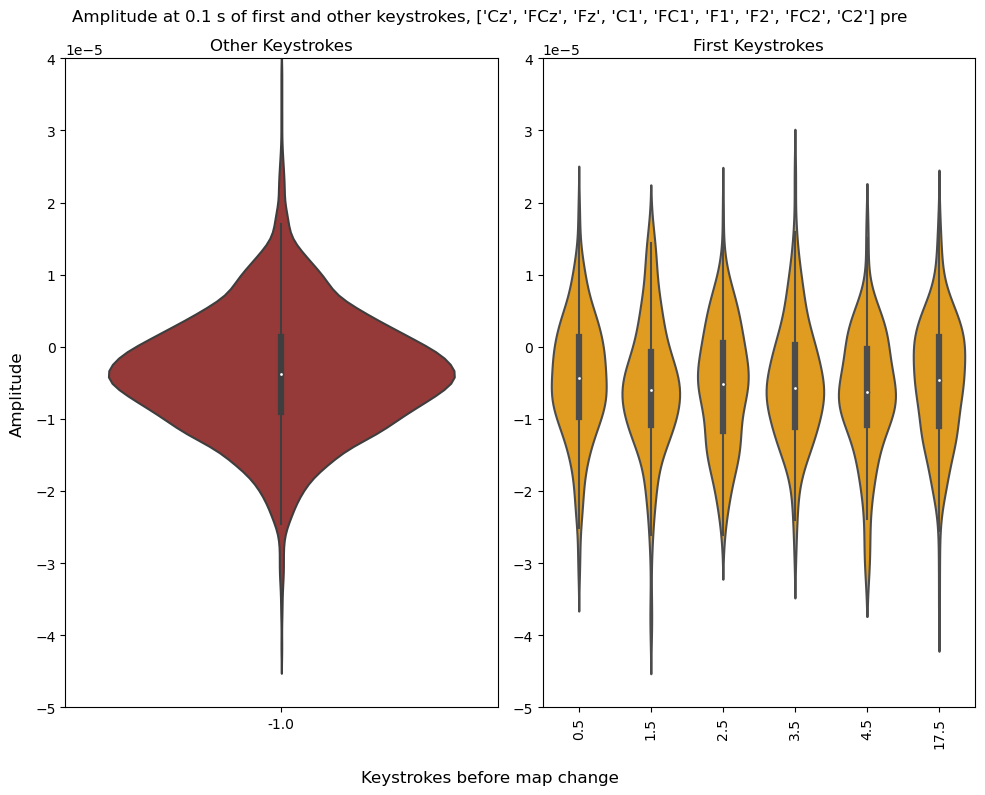

In [150]:

fig, axes = plt.subplots(1,2, figsize = (10,8))

# Create the violin plot, aligning it with the scatter plot
sns.violinplot(x=firsts_xcut, y=firsts_y, color='orange', ax = axes[1])
sns.violinplot(x=others_x, y=others_y, color='brown', ax = axes[0])
# sns.stripplot(x=firsts_xcut, y=firsts_y, color='grey', ax = axes[1], alpha = 0.4)
# sns.stripplot(x=others_x, y=others_y, color='grey', ax = axes[0],alpha = 0.4)


plt.setp(axes, ylim=(-0.00005, 0.00004))

# Add titles to each subplot
axes[0].set_title('Other Keystrokes', fontsize=12)
axes[1].set_title('First Keystrokes', fontsize=12)
axes[1].set_xticklabels(labels = x_labels, rotation= 90)

# Customize plot
fig.supylabel('Amplitude')
fig.supxlabel('Keystrokes before map change')
fig.suptitle(f'Amplitude at {time_to_plot} s of first and other keystrokes, {ch_to_plot} {period}')
plt.tight_layout()
plt.ylim(-0.00005, 0.00004)
#plt.hlines(0, 0, 30, color='black')

plt.tight_layout()

01
(285, 5) (285, 72, 129)
05
(303, 5) (303, 72, 129)
06
(369, 5) (369, 72, 129)
07
(373, 5) (373, 72, 129)
08
(267, 5) (267, 72, 129)
09
(394, 5) (394, 72, 129)
10
(283, 5) (283, 72, 129)
11
(402, 5) (402, 72, 129)
12
(281, 5) (281, 72, 129)
13
(398, 5) (398, 72, 129)
14
(310, 5) (310, 72, 129)
15
(445, 5) (445, 72, 129)
16
(289, 5) (289, 72, 129)
17
(395, 5) (395, 72, 129)
18
(294, 5) (294, 72, 129)
19
(395, 5) (395, 72, 129)
20
(356, 5) (356, 72, 129)


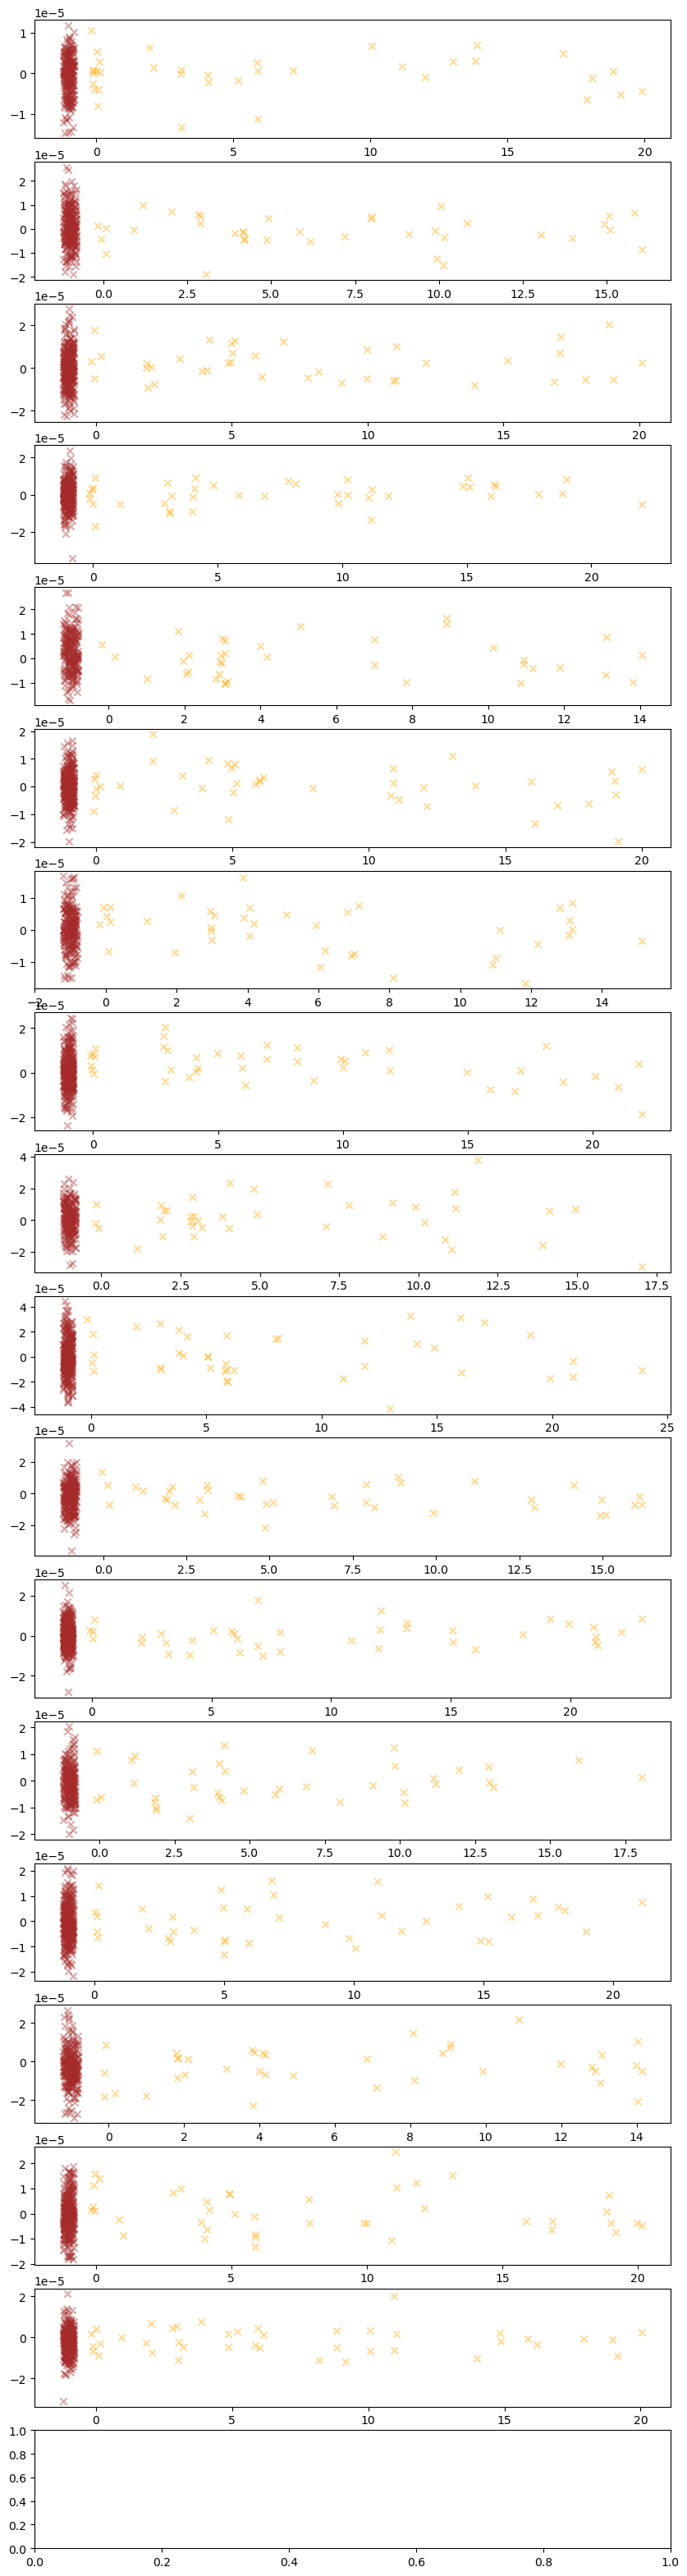

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

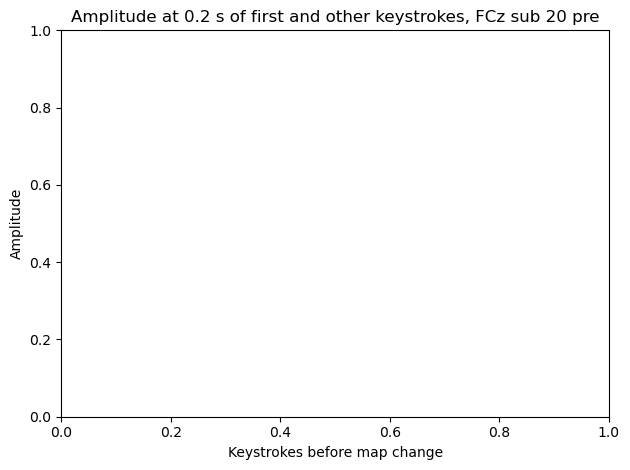

In [157]:
"""good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects

#17 post has a shorter length

period = 'pre'
ch_to_plot = 'FCz'
ch_idx = ch_index([ch_to_plot])[0]

time_to_plot = 0.2
time_idx = time_index([time_to_plot])[0]

ep_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data_n05to05_30Hz'
mapchange_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv'

fig, axes = plt.subplots(18, 1, figsize = (10,40))
#for k, sub in enumerate([s for s in subjects_to_process if s != '04']):
for k, sub in enumerate([s for s in subjects_to_process if s != '04']):

    print(sub)
    #read epochs data
    ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
    eps = mne.read_epochs(ep_file).get_data()

    #read mapchange data
    mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
    mapchange_df = pd.read_csv(mapchange_file)
    mapchange_df_firsts = mapchange_df.query('type =="first"')
    mapchange_df_others = mapchange_df.query('type =="other"')

    print(mapchange_df.shape, eps.shape)

    plt.figure()
    for i, row in mapchange_df_firsts.iterrows():
        keystroke_idx = row['keystroke_idx']
        jitter_x = row['prev_keystrokes'] + np.random.uniform(-0.2, 0.2)
        #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'orange', marker = 'x', alpha = 0.4)
        axes[k].scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'orange', marker = 'x', alpha = 0.4)



    for i, row in mapchange_df_others.iterrows():
        keystroke_idx = row['keystroke_idx']
        jitter_x = -1 + np.random.uniform(-0.2, 0.2)
        #plt.scatter(jitter_x, np.min(eps[keystroke_idx, ch_idx]), color = 'brown', marker = 'x', alpha = 0.4)
        axes[k].scatter(jitter_x, eps[keystroke_idx, ch_idx, time_idx], color = 'brown', marker = 'x', alpha = 0.4)
  

#plt.hlines(0,0,max(mapchange_df_firsts['prev_keystrokes']), color = 'black')
plt.ylabel('Amplitude')
plt.xlabel('Keystrokes before map change')
plt.title(f'Amplitude at {time_to_plot} s of first and other keystrokes, {ch_to_plot} sub {sub} {period}')
plt.tight_layout()"""

### Difference within subjects

In [5]:
time_to_plot = [0.08, 0.12]
#time_to_plot = [0.1]
time_idx = time_index_custom(time_to_plot, erp_times)

ch_to_plot = ['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2']
#ch_to_plot = ['FCz']
ch_idx = ch_index(ch_to_plot)


periods = ['pre', 'post']

data_f = []
data_o = []

col = 'orange'
for k, sub in enumerate(subjects_to_process):
    for period in periods:

        # Read epochs data
        ep_file = os.path.join(ep_path, f'error_epochs_all_{period}_{sub}.fif')
        eps = mne.read_epochs(ep_file).get_data()

        # Read mapchange data
        mapchange_file = os.path.join(mapchange_path, f'mapchange_keystrokes_{period}_{sub}.csv')
        mapchange_df = pd.read_csv(mapchange_file)
        mapchange_df_firsts = mapchange_df.query('type =="first"')
        mapchange_df_others = mapchange_df.query('type =="other"')


        #add to dataframe for the first keystrokes
        for i, row in mapchange_df_firsts.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                prev_keystrokes = row['prev_keystrokes']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx]) #include multiple channels and single timepoint
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]]) #include multiple timepoint and single channel
                amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1)) #include multiple time points and multiple channels
                data_f.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'first',
                    'prev_keystrokes': prev_keystrokes,
                    'amp_f': amp
                })
                
                

            except IndexError: 
                print(f'failed to convert keystrokes for {sub}')
                continue
            
        for i, row in mapchange_df_others.iterrows():
            try:
                keystroke_idx = row['keystroke_idx']
                #amp = np.mean(eps[keystroke_idx, ch_idx, time_idx])
                #amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]])
                amp = np.min(eps[keystroke_idx, ch_idx, time_idx[0]:time_idx[1]].mean(axis = 1))
                data_o.append({
                    'subject': sub,
                    'period': period,
                    'epochtype': 'other',
                    'prev_keystrokes': -1,
                    'amp_o': amp
                    })
                
            
            except IndexError:
                print(f'failed to plot {sub}')
                continue 

f_df = pd.DataFrame(data_f)
o_df = pd.DataFrame(data_o)

failed to plot 04
failed to plot 17


In [6]:
# get average erp for others 
periods =['pre', 'post']
data_o_ave = []
for sub in subjects_to_process:
    for period in periods:
        o_df_sub = o_df.query(f'subject == "{sub}" and period == "{period}"')
        aveamp = o_df_sub['amp_o'].mean()
    
        data_o_ave.append(
            {'subject': sub,
            'period': period,
            'aveamp_o': aveamp}
        )

data_o_ave = pd.DataFrame(data_o_ave)

In [7]:
#subtract average of all others from each first ERP 
df_diff = pd.merge(f_df, data_o_ave, on=['subject', 'period'])
df_diff['diff'] = df_diff['amp_f']-df_diff['aveamp_o']

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Difference amplitude - ave amplitude of others')

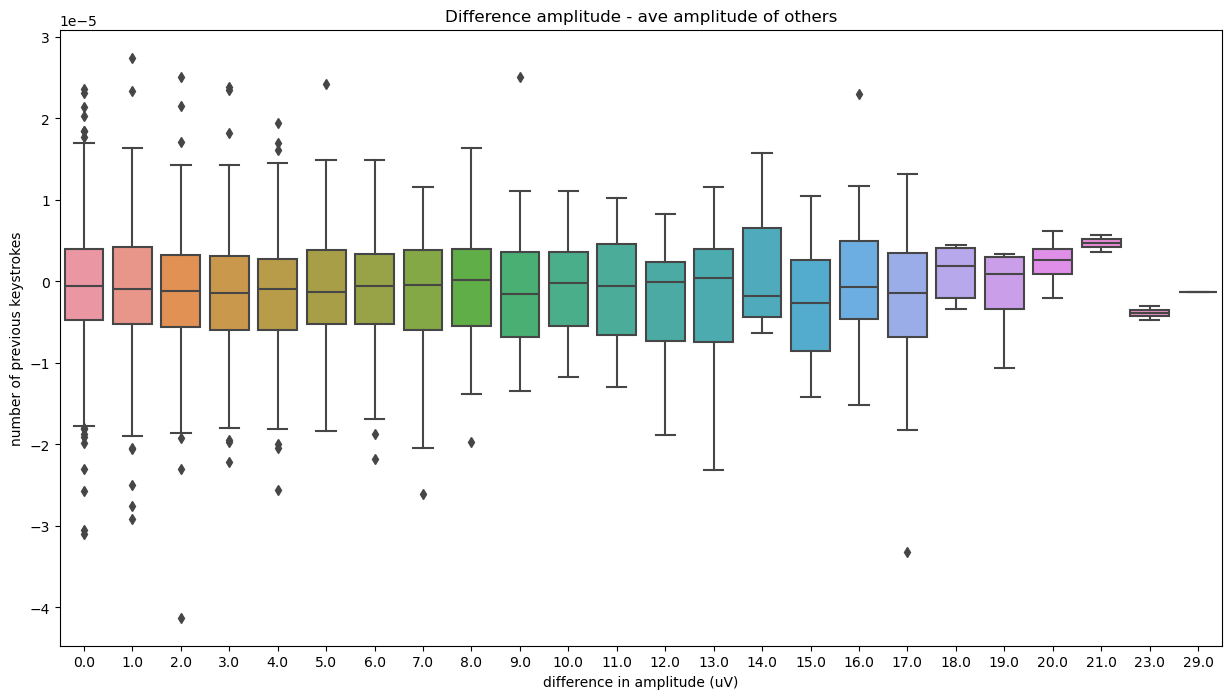

In [8]:
plt.figure(figsize=(15,8))
#sns.boxplot(data = df_diff[df_diff['period'] == 'post'], x = 'prev_keystrokes', y = 'diff')
sns.boxplot(data = df_diff, x = 'prev_keystrokes', y = 'diff')
plt.xlabel('difference in amplitude (uV)')
plt.xlabel('difference in amplitude (uV)')
plt.ylabel('number of previous keystrokes')
plt.title('Difference amplitude - ave amplitude of others')

/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/cindyzhang/anaconda3/envs/eelbrain-cnsp/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


Text(0.5, 1.0, "['Cz', 'FCz', 'Fz', 'C1', 'FC1', 'F1', 'F2', 'FC2', 'C2'], pre, min 0.08-1.2s")

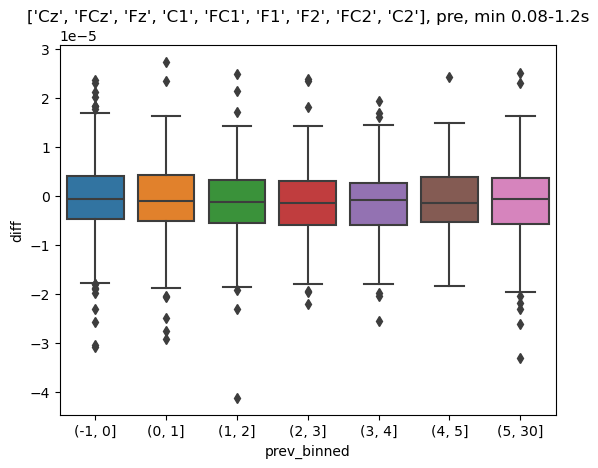

In [9]:
period = 'pre'

df_diff['prev_binned'] = pd.cut(df_diff['prev_keystrokes'], [-1,0,1,2,3,4,5,30])
sns.boxplot(data=df_diff, x = 'prev_binned', y = 'diff')
#sns.violinplot(data=df_diff[df_diff['period']==period], x = 'prev_binned', y = 'diff')
#plt.ylim(-6e-6,6e-6)
plt.title(f'{ch_to_plot}, {period}, min 0.08-1.2s')

Stats on differences

In [26]:
df_diff

,subject,period,epochtype,prev_keystrokes,amp_f,aveamp_o,diff,prev_binned
0,01,pre,first,0.0,2.293564e-06,-0.000004,6.543359e-06,"(-1, 0]"
1,01,pre,first,4.0,-4.270051e-07,-0.000004,3.822790e-06,"(3, 4]"
2,01,pre,first,2.0,-6.010803e-06,-0.000004,-1.761008e-06,"(1, 2]"
3,01,pre,first,4.0,-1.091931e-05,-0.000004,-6.669519e-06,"(3, 4]"
4,01,pre,first,7.0,-7.399103e-06,-0.000004,-3.149308e-06,"(5, 30]"
...,...,...,...,...,...,...,...,...
2825,20,post,first,0.0,-3.267738e-06,-0.000005,1.360300e-06,"(-1, 0]"
2826,20,post,first,11.0,-1.150587e-05,-0.000005,-6.877827e-06,"(5, 30]"
2827,20,post,first,5.0,-6.855872e-06,-0.000005,-2.227833e-06,"(4, 5]"
2828,20,post,first,0.0,4.387162e-06,-0.000005,9.015200e-06,"(-1, 0]"


In [55]:
firsts_0 = df_diff[df_diff['prev_keystrokes']==0]['diff'].values
firsts_1 = df_diff[df_diff['prev_keystrokes']==1]['diff'].values
firsts_2 = df_diff[df_diff['prev_keystrokes']==2]['diff'].values
firsts_3 =  df_diff[df_diff['prev_keystrokes']==3]['diff'].values
firsts_4 =  df_diff[df_diff['prev_keystrokes']==4]['diff'].values

In [65]:
stats.ttest_ind(firsts_0, firsts_1)


TtestResult(statistic=0.6454886455860531, pvalue=0.5187180352591507, df=1378.0)

In [39]:
all_firsts = df_diff['diff'].values

In [42]:
wilcoxon_1samp(all_firsts)

WilcoxonResult(statistic=1699779.0, pvalue=3.088806991273198e-12)

In [54]:
wilcoxon_1samp(firsts_1)

WilcoxonResult(statistic=109754.0, pvalue=0.003839368425261758)